<a href="https://colab.research.google.com/github/cesar-claros/synergistic/blob/master/PhysionetChallenge2012_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch
!pip install gpytorch

In [ ]:
! sudo apt-get install texlive-latex-recommended #1
! sudo apt-get install dvipng texlive-fonts-recommended #2
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip #3
! unzip type1cm.zip -d /tmp/type1cm #4
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins  #5
! sudo mkdir /usr/share/texmf/tex/latex/type1cm #6
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm #7
! sudo texhash #8

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!cp -r "drive/My Drive/NIPS2020/auxfunc/" .
!cp -r "drive/My Drive/NIPS2020/datasets/" .
!cp -r "drive/My Drive/NIPS2020/style/" .
!cp -r "drive/My Drive/NIPS2020/runs/" .

In [ ]:
%load_ext tensorboard

In [7]:
# %%
# Imports
import io #Used as buffer
import sys
import matplotlib
import tensorflow as tf # Keras model for MNIST 
# matplotlib.use('qt5Agg')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import auxfunc.sigfunc as sgn
import seaborn as sns
import torch
from scipy.stats import entropy, spearmanr
from sklearn import model_selection, svm, ensemble, linear_model, pipeline, \
      tree, neighbors, discriminant_analysis, gaussian_process, preprocessing, impute, decomposition
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, Matern
plt.style.use(['ggplot','style/style.mplstyle'])

In [8]:
#%%
# Define classic MLP architecture
def MLP_model(input_dim, objective='svm', reg=0.01):
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(
            units=128, kernel_initializer='uniform', activation='relu',
            input_dim=input_dim
    ))
    model.add(tf.keras.layers.Dense(
            units=64, kernel_initializer='uniform', activation='relu'
    ))
    if objective == 'svm':
        model.add(tf.keras.layers.Dense(
            units=1, kernel_initializer='uniform', activation='linear', kernel_regularizer=tf.keras.regularizers.l2(reg)
        ))
    elif objective == 'softmax':
        model.add(tf.keras.layers.Dense(
            units=1, kernel_initializer='uniform', activation='sigmoid'
        ))
    return model

In [9]:
#%%
# Signaling function fitting and evaluation
def signalingFunction(X_train, y_train, y_train_pred_th, X_val, y_val, y_val_pred_th, X_test, y_test, y_test_pred_th, kernel='exponential', norm='l01'):
    # X_train, X_val should be scaled
    # Fit signaling function 
    exp = sgn.signaling(norm=norm) # idx = [train,test,val]
    exp.fit(X_train, y_train, y_train_pred_th, kernel=kernel, n_iter=500, lr=0.01)
    table_val = exp.evaluate(X_val, y_val, y_val_pred_th, rule_grid=np.linspace(0,3,30, endpoint=False))
    table_test = exp.test(X_test, y_test, y_test_pred_th, table_val['rule'].to_numpy(), table_val['eta'].to_numpy())
    table = pd.concat([table_val,table_test],axis=1)
    return table, exp

In [10]:
#%%
# Initialize model
def init_model(input_dim, objective):
    model = MLP_model(input_dim=input_dim, objective=objective)
    if objective=='svm':
        loss = tf.keras.losses.hinge
        metric = ['hinge']

    elif objective=='softmax':
        loss = tf.keras.losses.binary_crossentropy
        metric = ['accuracy']

    model.compile(loss=loss,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=metric)
    # model.summary()
    print('loss={}'.format(loss.__name__))
    return model

In [11]:
#%%
# Soft and thresholded output predictions
def pred_output(model, X, objective):
    if objective=='svm':
        y_pred_soft = model.predict(X)
        y_pred_th = np.array([1 if i[0] >= 0 else 0 for i in y_pred_soft])
    elif objective=='softmax':
        y_pred_soft = model.predict(X)
        y_pred_th = np.array([1 if i[0] > 0.5 else 0 for i in y_pred_soft])
    return y_pred_soft, y_pred_th

In [12]:
#%%
# Jaccard similarity index
def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

In [13]:
#%%
# Baseline comparison
def baselineCriteria(y_val, y_val_pred_soft, y_val_pred_th, y_test, y_test_pred_soft, y_test_pred_th, table, exp, clf):
      if clf=='svm':
          direction = 'closer'
          crit_val = np.abs(y_val_pred_soft.ravel())
          crit_test = np.abs(y_test_pred_soft.ravel())
      else:
          direction = 'further'
          p_val = np.concatenate((y_val_pred_soft,1-y_val_pred_soft),axis=1)
          crit_val = entropy(p_val, axis=1, base=2)
          p_test = np.concatenate((y_test_pred_soft,1-y_test_pred_soft),axis=1)
          crit_test = entropy(p_test, axis=1, base=2)
      
      critFunc = sgn.critEvaluation(norm='l01',direction=direction)
      d_val = critFunc.evaluate(y_val, y_val_pred_th, crit_val)
      d_test = critFunc.test(y_test, y_test_pred_th, crit_test, d_val['thresh'].to_numpy())
      crit_table = pd.concat([d_val,d_test],axis=1)

      gamma = table['rule'].to_numpy().reshape(-1,1)
      f_test = exp.gpr_mean_test + gamma*np.sqrt(exp.gpr_var_test)
      eta = table['eta'].to_numpy().reshape(-1,1)
      theta = crit_table['thresh'].to_numpy().reshape(-1,1)
      if direction == 'closer':
        f_mask, f_idx = np.nonzero(f_test>eta)
      else:
        f_mask, f_idx = np.nonzero(f_test<eta)
      crit_mask, crit_idx = np.nonzero(crit_test.reshape(1,-1)<theta)
      print(list(np.unique(f_mask)))
      print(list(np.unique(crit_mask)))
      print(f_test.shape[0])
      shared = set(list(np.unique(f_mask))).intersection(set(list(np.unique(crit_mask))))
      J = [jaccard_similarity(crit_idx[crit_mask==i],f_idx[f_mask==i]) if i in shared else np.nan for i in range(f_test.shape[0])]
      # if (list(np.unique(f_mask))==list(np.unique(crit_mask))):
      #   J = [jaccard_similarity(crit_idx[crit_mask==i],f_idx[f_mask==i]) for i in np.unique(f_mask)]
      # else:
      #   shared = set(a).intersection(set(b))
      #   union = set(a).union(set(b))
      #   J = [jaccard_similarity(crit_idx[crit_mask==i],f_idx[f_mask==i]) if i in shared else np.nan  for i in union]
      crit_table['jaccard']=J
      Sp = [spearmanr(f_test[i,:],crit_test)[0] for i in range(f_test.shape[0])]
      crit_table['spearman'] = Sp
      crit_table['gamma'] = gamma
      return crit_table

In [54]:
# %%
# INITIALIZATION
# ==============
# EXPERIMENT SETUP
# ================
# Load data
# -------------
df = pd.read_csv('https://raw.githubusercontent.com/ckbjimmy/2018_mlw/master/data/PhysionetChallenge2012_data.csv')
Data_X = df.iloc[:, 1:].values
Data_y = df.iloc[:, 0].values
# %%
# For reproducibility
tf.random.set_seed(54321)
np.random.seed(12345)
torch.manual_seed(0)

In [55]:
#%%
# Assign labels
report_table = []
report_criteria = []
report_plot = []
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=321)
clf = 'softmax'
addPredictions = True
applyPCA = True
for sample, test in kf.split(Data_X):
    X = Data_X[sample]
    y = Data_y[sample]
    imputeX = impute.SimpleImputer(missing_values=np.nan, strategy='mean').fit(X)
    X = imputeX.transform(X)
    scaleX = preprocessing.StandardScaler().fit(X)
    X = scaleX.transform(X)
    X_train, X_val, y_train, y_val = model_selection.train_test_split(X, y, test_size=0.20, random_state=123)
    X_test = Data_X[test]
    y_test = Data_y[test]

    # TRAINING MODEL
    model = init_model(input_dim=X.shape[1], objective=clf)
    model.fit(X_train, y_train, batch_size=64, epochs=5, verbose=0, validation_data=(X_val, y_val))
    X_test = scaleX.transform(imputeX.transform(X_test))

    y_train_pred_soft, y_train_pred_th = pred_output(model, X_train, clf)
    print('accuracy(Train)={}'.format(np.sum(y_train==y_train_pred_th)/np.size(y_train)))
    y_val_pred_soft, y_val_pred_th = pred_output(model, X_val, clf)
    y_test_pred_soft, y_test_pred_th = pred_output(model, X_test, clf)

    X_train_GP = X_train
    X_val_GP = X_val
    X_test_GP = X_test
    if addPredictions:
            # Add predictions
            X_train_GP = np.concatenate((X_train, y_train_pred_soft), axis=1)
            X_val_GP = np.concatenate((X_val, y_val_pred_soft), axis=1)
            X_test_GP = np.concatenate((X_test, y_test_pred_soft), axis=1)
    scaleX_GP = preprocessing.StandardScaler().fit(np.concatenate((X_train_GP, X_val_GP), axis=0))
    X_train_GP = scaleX_GP.transform(X_train_GP)
    X_val_GP = scaleX_GP.transform(X_val_GP)
    X_test_GP = scaleX_GP.transform(X_test_GP)
    if applyPCA:
            pca_GP = decomposition.PCA(.99).fit(np.concatenate((X_train_GP, X_val_GP), axis=0)) # set percentage of energy preserved by PCA
            # Apply PCA transform to all sets
            X_train_GP = pca_GP.transform(X_train_GP)
            X_val_GP = pca_GP.transform(X_val_GP)
            X_test_GP = pca_GP.transform(X_test_GP)

    table, exp = signalingFunction(X_train_GP, y_train, y_train_pred_th, X_val_GP, y_val, y_val_pred_th, X_test_GP, y_test, y_test_pred_th)
    report_table.append(table)
    # Baseline for comparison
    crit_table = baselineCriteria(y_val, y_val_pred_soft, y_val_pred_th, y_test, y_test_pred_soft, y_test_pred_th, table, exp, clf)
    report_criteria.append(crit_table)
    del(model)

loss=binary_crossentropy
accuracy(Train)=0.8703125
initializing cuda...
lr=0.01, n_iterations=500
Iter 491/500 - Loss: 0.188  noise: 0.036
Iter 492/500 - Loss: 0.188  noise: 0.036
Iter 493/500 - Loss: 0.189  noise: 0.036
Iter 494/500 - Loss: 0.190  noise: 0.036
Iter 495/500 - Loss: 0.189  noise: 0.036
Iter 496/500 - Loss: 0.189  noise: 0.036
Iter 497/500 - Loss: 0.188  noise: 0.036
Iter 498/500 - Loss: 0.188  noise: 0.036
Iter 499/500 - Loss: 0.188  noise: 0.036
Iter 500/500 - Loss: 0.187  noise: 0.036
evaluating with cuda...
evaluating with cuda...
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]
5
loss=binary_crossentropy
accuracy(Train)=0.911328125
initializing cuda...
lr=0.01, n_iterations=500
Iter 491/500 - Loss: 0.112  noise: 0.035
Iter 492/500 - Loss: 0.111  noise: 0.035
Iter 493/500 - Loss: 0.109  noise: 0.035
Iter 494/500 - Loss: 0.110  noise: 0.035
Iter 495/500 - Loss: 0.109  noise: 0.035
Iter 496/500 - Loss: 0.111  noise: 0.035
Iter 497/500 - Loss: 0.110  noise: 0.035
Iter 498/500 - Loss: 0.

In [ ]:
logs_base_dir = "runs/"
%tensorboard --logdir {logs_base_dir}

In [56]:
##%
# Boxplot (loss reduction in test set)
report_table_concat = pd.concat(report_table)
cols_table = ['p_value','rho_user','%reduction_test']
df_boxplot_table = pd.DataFrame(report_table_concat[cols_table])
df_boxplot_table['label'] = df_boxplot_table.shape[0]*['$f(x)$']
report_criteria_concat = pd.concat(report_criteria)
columns_crit = ['rho_user','%reduction_test']
df_boxplot_crit = pd.DataFrame(report_criteria_concat[columns_crit])
df_boxplot_crit['label'] = df_boxplot_crit.shape[0]*['$g(x)$']
# p-value median
p_value_by_row_index = df_boxplot_table['p_value'].groupby(df_boxplot_table.index)
p_value_median = p_value_by_row_index.median()
# Boxplot (jaccard index in test set)
columns_jac = ['rho_user','jaccard']
df_jaccard = pd.DataFrame(report_criteria_concat[columns_jac])
# Unfiltered Result dataframes
cols_fx = ['rho_user','%reduction_val','budget','%reduction_test']
results_fx = pd.DataFrame(report_table_concat[cols_fx])
cols_fxgx = ['rho_user','%reduction_test', 'jaccard']
results_fxgx = pd.concat([df_boxplot_table[cols_fxgx[:2]], df_boxplot_crit[cols_fxgx[1]], df_jaccard[cols_fxgx[2]]], axis=1)
# Filter experiments with p_value > 0.05
df_boxplot_crit = df_boxplot_crit.loc[df_boxplot_table['p_value'] <= 0.05]
df_jaccard = df_jaccard.loc[df_boxplot_table['p_value'] <= 0.05]
df_boxplot_table = df_boxplot_table.loc[df_boxplot_table['p_value'] <= 0.05]
# Boxplot with filtered values only
frames = [df_boxplot_table, df_boxplot_crit]
df = pd.concat(frames)

In [57]:
# Avoid plotting when median(p_value)>0.5
for i in range(p_value_median.shape[0]):
    if p_value_median.iloc[i]>0.05:
      df.loc[df.index==i,'%reduction_test'] = np.nan
      df_jaccard.loc[df_jaccard.index==i, 'jaccard'] = np.nan

In [58]:
# Dataframe for results f(x)
results_fx_by_row_index = results_fx.groupby(results_fx.index)
fx_median = results_fx_by_row_index.median()
fx_q1 = results_fx_by_row_index.quantile(q=0.25)
fx_q3 = results_fx_by_row_index.quantile(q=0.75)
# Signaling function statistics (median(q1-q3)) LaTex
output_fx = io.StringIO()
numRows = fx_median.shape[0]
numCols = fx_median.shape[1]
output_fx.write("results_fx (\\rho|%reduction_val|sig_rate|%reduction_test|H0)\n")
output_fx.write("----------\n")
for i in range(numRows):
  row = [r'{:.2f}'.format(val1) if p_value_median[i]>0.05 and j==0 else r'{}' if p_value_median[i]>0.05 and j!=0\
         else r'{:.2f}'.format(val1) if (j==0) else r'{:.2f}({:.2f}-{:.2f})'.format(val1,val2,val3) if (j==2)\
         else r'{:.1f}({:.1f}-{:.1f})'.format(val1,val2,val3) for val1,val2,val3,j in zip(fx_median.iloc[i],fx_q1.iloc[i],fx_q3.iloc[i],range(numCols))]
  output_fx.write("{{}} & {{}} & %s & {H0} \\\\\n".format(H0=r'$\surd$' if p_value_median[i]<=0.05 else r'$\times$')%(" & ".join(row)))
print(output_fx.getvalue())

results_fx (\rho|%reduction_val|sig_rate|%reduction_test|H0)
----------
{} & {} & 0.01 & 3.1(2.6-4.3) & 0.01(0.01-0.01) & 4.7(2.8-4.8) & $\surd$ \\
{} & {} & 0.05 & 15.8(15.7-18.8) & 0.05(0.04-0.06) & 15.9(12.2-17.1) & $\surd$ \\
{} & {} & 0.10 & 30.0(28.0-31.2) & 0.10(0.10-0.11) & 31.8(29.0-32.4) & $\surd$ \\
{} & {} & 0.15 & 42.7(40.0-43.8) & 0.16(0.16-0.17) & 48.6(37.4-49.5) & $\surd$ \\
{} & {} & 0.20 & 52.1(51.7-53.3) & 0.20(0.20-0.22) & 54.2(43.9-55.2) & $\surd$ \\



In [59]:
# Dataframe for comparison f(x)-g(x)
results_fxgx_by_row_index = results_fxgx.groupby(results_fxgx.index)
fxgx_median = results_fxgx_by_row_index.median()
fxgx_q1 = results_fxgx_by_row_index.quantile(q=0.25)
fxgx_q3 = results_fxgx_by_row_index.quantile(q=0.75)
# Baseline comparison statistics (median(q1-q3)) LaTex
output_fxgx = io.StringIO()
numRows = fxgx_median.shape[0]
numCols = fxgx_median.shape[1]
output_fxgx.write("results_fxgx (\\rho|%reduction_test(fx)|%reduction_test(fxgx)|Jaccard|H0\n")
output_fxgx.write("------------\n")
for i in range(numRows):
  row = [r'{:.2f}'.format(val1) if p_value_median[i]>0.05 and j==0 else r'{}' if p_value_median[i]>0.05 and j!=0\
         else r'{:.2f}'.format(val1) if (j==0) else r'{:.2f}({:.2f}-{:.2f})'.format(val1,val2,val3) if (j==3)\
         else r'{:.1f}({:.1f}-{:.1f})'.format(val1,val2,val3) for val1,val2,val3,j in zip(fxgx_median.iloc[i],fxgx_q1.iloc[i],fxgx_q3.iloc[i],range(numCols))]
  output_fxgx.write("{{}} & {{}} & %s & {H0} \\\\\n".format(H0=r'$\surd$' if p_value_median[i]<=0.05 else r'$\times$')%(" & ".join(row)))
print(output_fxgx.getvalue())

results_fxgx (\rho|%reduction_test(fx)|%reduction_test(fxgx)|Jaccard|H0
------------
{} & {} & 0.01 & 4.7(2.8-4.8) & 3.8(2.9-4.8) & 0.98(0.98-0.98) & $\surd$ \\
{} & {} & 0.05 & 15.9(12.2-17.1) & 16.8(13.3-18.7) & 0.94(0.93-0.95) & $\surd$ \\
{} & {} & 0.10 & 31.8(29.0-32.4) & 34.3(26.7-35.5) & 0.92(0.90-0.92) & $\surd$ \\
{} & {} & 0.15 & 48.6(37.4-49.5) & 45.8(43.0-46.7) & 0.90(0.89-0.92) & $\surd$ \\
{} & {} & 0.20 & 54.2(43.9-55.2) & 54.2(54.2-55.2) & 0.90(0.89-0.91) & $\surd$ \\



In [60]:
#%%
# Save results in csv fomat
path_csv = "drive/My Drive/NIPS2020/results/physionetchallenge2012/results_{clf}_yhat{yhat}_pca{pca}.csv".format(clf=clf, pca=applyPCA, yhat=addPredictions)
results = pd.concat([results_fx, results_fxgx], keys=['fx', 'fxgx'], axis=1).to_csv(path_csv, index=True, header=True)
# Save results in tex fomat
L = [output_fx.getvalue(),output_fxgx.getvalue()]
path_txt = "drive/My Drive/NIPS2020/results/physionetchallenge2012/results_{clf}_yhat{yhat}_pca{pca}.txt".format(clf=clf, pca=applyPCA, yhat=addPredictions)
txt = open(path_txt, "w") 
txt.writelines(L) 
txt.close() #to change file access modes

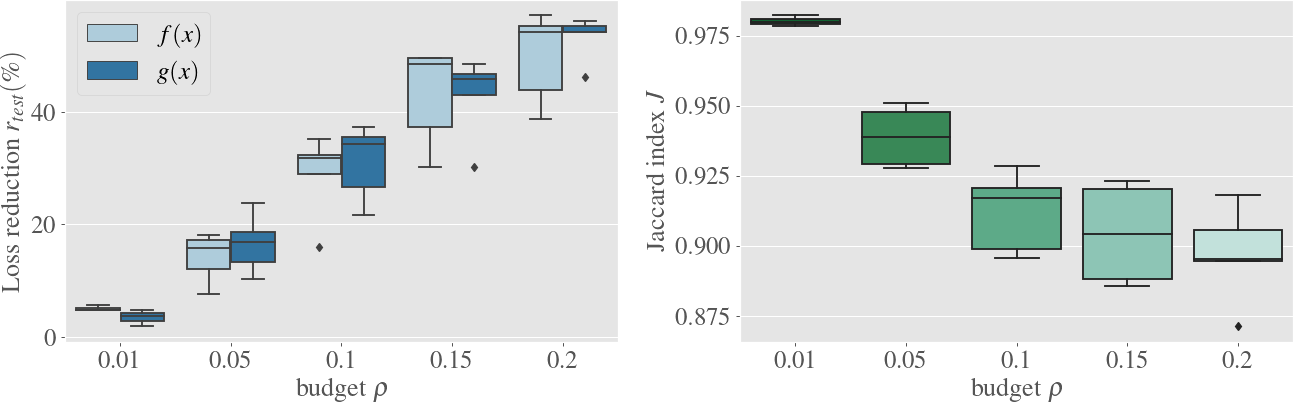

In [61]:
fig, ax = plt.subplots(1,2,figsize=(15, 5.1), constrained_layout=False, dpi=90)
pal = sns.color_palette('Paired')
sns.boxplot(x=df['rho_user'], y=df['%reduction_test'], hue='label', data=df, ax=ax[0], palette=pal)
ax[0].set_xlabel(r'budget $\rho$')
ax[0].set_ylabel(r'Loss reduction $r_{test}(\%)$')
ax[0].legend(loc='upper left')
pal = sns.color_palette('BuGn_r')
sns.boxplot(x=df_jaccard['rho_user'], y=df_jaccard['jaccard'], data=df_jaccard, ax=ax[1], palette=pal)
ax[1].set_xlabel(r'budget $\rho$')
ax[1].set_ylabel(r'Jaccard index $J$')
plt.tight_layout()
path_fig_fxgx = "drive/My Drive/NIPS2020/results/physionetchallenge2012/fig_fxgx_{clf}_yhat{yhat}_pca{pca}.pdf".format(clf=clf, pca=applyPCA, yhat=addPredictions)
plt.savefig(path_fig_fxgx, bbox_inches='tight', facecolor='w')

In [ ]:
report_table_concat = pd.concat(report_table)
table_by_row_index = report_table_concat.groupby(report_table_concat.index)
report_table_mean = table_by_row_index.mean()
report_table_std = table_by_row_index.std()

report_criteria_concat = pd.concat(report_criteria)
table_by_row_index = report_criteria_concat.groupby(report_criteria_concat.index)
report_criteria_mean = table_by_row_index.mean()
report_criteria_std = table_by_row_index.std()

In [ ]:
report_table_mean

In [ ]:
report_criteria_mean

In [ ]:
output = io.StringIO()
columns = ['%reduction_val','budget','%reduction_test']
df1=report_table_mean[columns]
df2=report_table_std[columns]
pval = report_table_mean['p_value']
rho = report_table_mean['rho_user']
assert(df1.shape[0]==df2.shape[0])
numRows = df1.shape[0]
for i in range(numRows):
  row = [r"{:.2f}$\pm${:.2f}".format(val1,val2) if pval[i]<=0.05 else r"{}" for val1, val2 in zip(df1.iloc[i], df2.iloc[i])]
  output.write("{{}} & {{}} & {rho} & %s & {H0} \\\\\n".format(rho=rho[i],H0=r'$\surd$' if pval[i]<=0.05 else r'$\times$') % (" & ".join(row)))
print(output.getvalue())

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


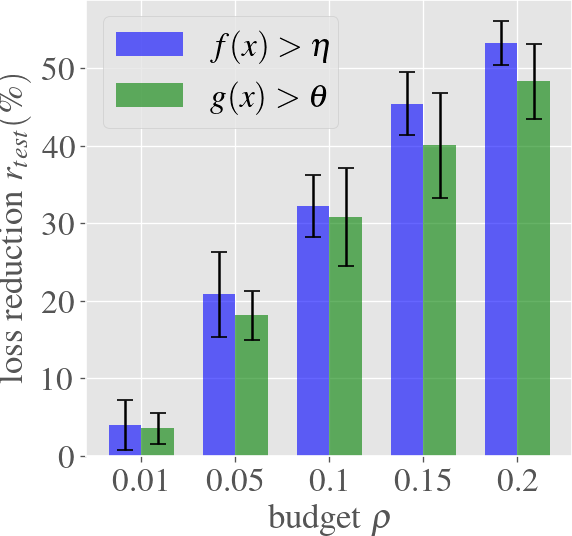

In [ ]:
# data to plot
means_table = report_table_mean['%reduction_test'].to_numpy()
std_table = report_table_std['%reduction_test'].to_numpy()
means_crit = report_criteria_mean['%reduction_test'].to_numpy()
std_crit = report_criteria_std['%reduction_test'].to_numpy()
n_groups = means_table.size

# create plot
fig, ax = plt.subplots(figsize=(5.4, 5.1), constrained_layout=False, dpi=120)
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.6

rects1 = plt.bar(index, means_table, bar_width, yerr=std_table, capsize=5,
alpha=opacity, color='b', label=r'$f(x)>\eta$')

rects2 = plt.bar(index + bar_width, means_crit, bar_width, yerr=std_crit, capsize=5,
alpha=opacity, color='g', label=r'$g(x)>\theta$')

plt.xlabel(r'budget $\rho$')
plt.ylabel(r'loss reduction $r_{test}(\%)$')
# plt.title('Scores by person')
plt.xticks(index + bar_width/2, (['{}'.format(i) for i in report_table_mean['rho_user'].to_numpy()]))
plt.legend()

plt.tight_layout()
plt.show()